In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics

In [2]:
# Bring in modeling data
df = pd.read_csv('modeling_dfs/users_order_by_prev_dept.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

#join a dataframe with info on organic_produce specifically
df_org_produce = pd.read_csv('modeling_dfs/users_order_by_prev_org.csv')
df_org_produce.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.merge(df_org_produce[['order_id','organic_produce','any_organic_produce',
                              'organic_non_produce','any_organic_non_produce',
                              'organic_produce_prev','any_organic_produce_prev']],on='order_id')
display(df[['organic','organic_produce']].sample(10)) #sanity check for join because any_organic_produce should always be less

display(df.head(5))
display(len(df))

,organic,organic_produce
3554,1.0,0.0
100322,2.0,2.0
1432,9.0,3.0
114865,0.0,0.0
72858,0.0,0.0
51031,5.0,4.0
9911,2.0,2.0
25186,2.0,1.0
16789,14.0,9.0
18146,1.0,0.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,"('department', 'personal care')","('department', 'pets')","('department', 'produce')","('department', 'snacks')",organic_produce,any_organic_produce,organic_non_produce,any_organic_non_produce,organic_produce_prev,any_organic_produce_prev
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,0,0,0,3,0.0,False,3.0,True,0,False
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,0,0,4,1,1.0,True,5.0,True,3,True
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,0,0,5,0,3.0,True,2.0,True,3,True
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,0,0,4,1,0.0,False,1.0,True,3,True
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,0,0,7,0,7.0,True,2.0,True,2,True


131209

In [3]:
#transform order characteristics into more interpretable features based on shopping tendencies
df['morning'] = df['order_hour_of_day'].apply(lambda x: True if ((x>=4) & (x<12)) else False)
display(df[['order_hour_of_day','morning']].sample(10)) #check behaving as expected.

df['weekend'] = df['order_dow'].apply(lambda x: True if x in [0,1] else False)
display(df[['order_dow','weekend']].sample(10)) #check behaving as expected.

df['num_past_orders'] = df['order_number']-1

,order_hour_of_day,morning
48955,11,True
5943,2,False
69631,19,False
45610,19,False
10249,20,False
2689,19,False
16294,17,False
96986,11,True
78748,15,False
108666,21,False


,order_dow,weekend
81225,2,False
57943,0,True
56631,0,True
46493,5,False
17448,5,False
23801,2,False
39502,1,True
85050,6,False
168,3,False
119935,6,False


,product_id,product_name,organic,freq_rank,user_id,rec_rank
0,13176,Bag of Organic Bananas,1,2,1,1
1,21137,Organic Strawberries,1,3,1,2
2,24852,Banana,0,1,1,3
3,21903,Organic Baby Spinach,1,4,1,4
4,39275,Organic Blueberries,1,11,1,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b1621d0>]],
      dtype=object)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,organic_produce,any_organic_produce,organic_non_produce,any_organic_non_produce,organic_produce_prev,any_organic_produce_prev,morning,weekend,num_past_orders,pct_organic
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,0.0,False,3.0,True,0,False,True,False,10,0.55
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,1.0,True,5.0,True,3,True,True,True,14,0.55
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,3.0,True,2.0,True,3,True,True,True,4,0.55
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,0.0,False,1.0,True,3,True,True,False,20,0.65
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,7.0,True,2.0,True,2,True,False,True,3,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3048078,78702,train,9,5,13,15.0,78702.009,78702.008,1891416.0,...,1.0,True,0.0,False,1,True,False,False,8,0.25
49996,1260736,78703,train,5,1,11,30.0,78703.005,78703.004,1827767.0,...,2.0,True,0.0,False,1,True,True,True,4,0.45
49997,2700517,78704,train,4,4,17,30.0,78704.004,78704.003,1286110.0,...,0.0,False,0.0,False,0,False,False,False,3,0.20
49998,2160403,78705,train,39,1,2,9.0,78705.039,78705.038,1042834.0,...,0.0,False,2.0,True,0,False,False,True,38,0.20


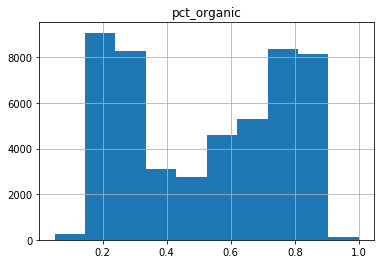

In [4]:
# import recommendation data to calculate the %organic items in the top 20 recommendations for each user

# only 50000 users because of time constraints
df_recs = pd.read_csv('top20_products_recom.csv')
df_recs.drop(['Unnamed: 0'],axis=1,inplace=True)
display(df_recs.head(5))

#group by organic column to get the sum of organic items in top 20 recs
user_pct_organic = df_recs[['user_id','organic']].groupby('user_id').sum()\
                        .rename({'organic':'pct_organic'},axis=1)/20
display(user_pct_organic.hist()) #very bimodal.
user_pct_organic.reset_index(inplace=True)

df = df.merge(user_pct_organic,on='user_id')
display(df)

In [5]:
# project departments into lower dimensional space using PCA
dept_cols = [colname for colname in df.columns.values if 'department' in colname] # include departments
dept_cols.remove("('department', 'missing')")# remove erroneous departments

num_pcs = 4 #select PCs with eigenvalues > 0.05 for relevance
pca = PCA(n_components=num_pcs)
pca.fit(df[dept_cols])
df_pca = pd.DataFrame(pca.transform(df[dept_cols]),columns=['PC{}'.format(x) for x in range(1,num_pcs+1)],
                           index=df.index)
df = df.join(df_pca)

In [6]:
# looking at what the PCs actually represent:

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
# print(pca.components_)
pca_comps = pd.DataFrame(pca.components_, columns=dept_cols)
# display(pca_comps)
pca_comps = pca_comps.transpose()
pca_comps.columns = ['PC{}'.format(x) for x in range(1,num_pcs+1)]
# display(pca_comps)

print('Principal component loadings, only abs>0.3')
for pcn,pc in enumerate(pca_comps.columns.values):
    print('PC{} ({}%)'.format(pcn+1,100*pca.explained_variance_ratio_[pcn]))
    pc_i = pd.DataFrame(pca_comps[pc])
    pc_i.loc[:,pc+'_abs'] = np.abs(pc_i[pc])
#     display(pc_i.sort_values(pc+'_abs',ascending=False))
    display(pc_i.loc[pc_i[pc+'_abs']>0.3].sort_values(pc+'_abs',ascending=False))

4
[0.45843677 0.13874772 0.08017576 0.0589898 ]
Principal component loadings, only abs>0.3
PC1 (45.8436770210271%)


,PC1,PC1_abs
"('department', 'produce')",0.950559,0.950559


PC2 (13.874772077428258%)


,PC2,PC2_abs
"('department', 'dairy eggs')",0.691317,0.691317
"('department', 'snacks')",0.466111,0.466111


PC3 (8.017576082808272%)


,PC3,PC3_abs
"('department', 'snacks')",0.674030,0.674030
"('department', 'dairy eggs')",-0.631524,0.631524
"('department', 'beverages')",0.322139,0.322139


PC4 (5.898979789730261%)


,PC4,PC4_abs
"('department', 'frozen')",0.885714,0.885714


In [7]:
# Rename PC predictors based on interpretation
df.rename({'PC1':'produce',
           'PC2':'dairyeggs_snacks',
           'PC3':'snacks_beverages_notdairyeggs',
           'PC4':'frozen_notsnacks'},axis=1,inplace=True)

In [18]:
# train the classifier on 80% of the data

y_col = 'any_organic_produce'
feature_cols = ['any_organic_produce_prev',
                'num_past_orders','weekend','morning','days_since_prior_order','pct_organic',
                'produce','dairyeggs_snacks','snacks_beverages_notdairyeggs','frozen_notsnacks']
# feature_cols = ['any_organic_produce_prev','pct_organic',]
print('Features:')
print(feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[y_col], test_size=0.20, random_state=22)

logisticRegr = LogisticRegression(penalty='l1',solver='liblinear')
logisticRegr.fit(X_train,y_train)


Features:
['any_organic_produce_prev', 'num_past_orders', 'weekend', 'morning', 'days_since_prior_order', 'pct_organic', 'produce', 'dairyeggs_snacks', 'snacks_beverages_notdairyeggs', 'frozen_notsnacks']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
predictions = logisticRegr.predict(df[feature_cols])
df['predicted_'+y_col] = predictions
# display(df[['predicted_'+y_col,y_col]])

print('predicted distribution:')
display(df['predicted_'+y_col].value_counts())
display(df['predicted_'+y_col].value_counts(normalize=True))
print('actual distribution:')
display(df[y_col].value_counts())
display(df[y_col].value_counts(normalize=True))

predicted distribution:


True     27822
False    22178
Name: predicted_any_organic_produce, dtype: int64

True     0.55644
False    0.44356
Name: predicted_any_organic_produce, dtype: float64

actual distribution:


True     27515
False    22485
Name: any_organic_produce, dtype: int64

True     0.5503
False    0.4497
Name: any_organic_produce, dtype: float64

training data:
Mean accuracy:
0.7601
F1 score:
0.7833077409448108
ROC AUC score:
0.7569663242641113
Confusion matrix:
[[13060  4937]
 [ 4659 17344]]
ROC curve


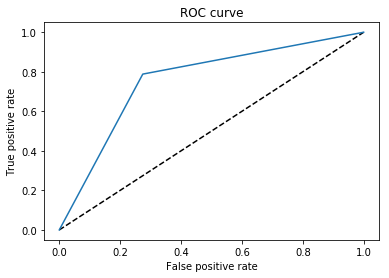

test data:
Mean accuracy:
0.7631
F1 score:
0.7856690491269339
ROC AUC score:
0.7602894931557529
Confusion matrix:
[[3289 1199]
 [1170 4342]]
ROC curve


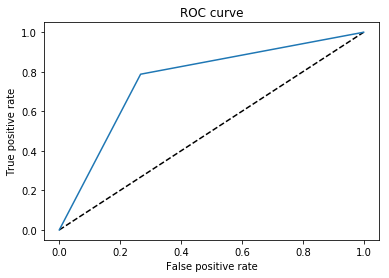

In [20]:
# Validation of model using built-in methods
def print_scores(X,y,model):
    print('Mean accuracy:')
    print(model.score(X,y))
    print('F1 score:')
    print(metrics.f1_score(y.astype(int),model.predict(X).astype(int)))
    print('ROC AUC score:')
    print(metrics.roc_auc_score(y.astype(int),model.predict(X).astype(int)))
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y, model.predict(X)))
    
    print('ROC curve')
    fpr, tpr, _ = metrics.roc_curve(y.astype(int),model.predict(X).astype(int))
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
print('training data:')
print_scores(X_train,y_train,logisticRegr)

print('test data:')
print_scores(X_test,y_test,logisticRegr)

#                       Predicted not-y,0   Predicted y,1
# True not-y,0
# True y,1

In [21]:
coefs = pd.DataFrame(list(zip(logisticRegr.coef_[0], feature_cols)),columns=['coef','feature'])
display(coefs.sort_values('coef'))

,coef,feature
8,-0.034382,snacks_beverages_notdairyeggs
7,-0.017846,dairyeggs_snacks
9,-0.004260,frozen_notsnacks
1,0.000634,num_past_orders
4,0.002560,days_since_prior_order
3,0.012555,morning
6,0.149918,produce
2,0.200769,weekend
0,1.246783,any_organic_produce_prev
5,2.609332,pct_organic


In [22]:
# export big organic strawberries model to pickle file
filename = 'saved_models/model_with_colab_filter_and_prev_produce.pkl'
pickle.dump(logisticRegr, open(filename, 'wb'))

#check export worked
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [24]:
# save df for targeting users later
df.to_csv('modeling_dfs/final_users_50k.csv')